In [38]:
!pip install torchattacks

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchattacks


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                 (0.5, 0.5, 0.5))])

batch_size=31


train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                             download=True, transform=transform)

val_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


classes = train_dataset.classes



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


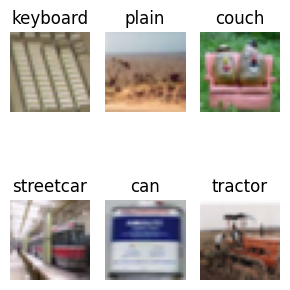

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

batch_size = 6

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Define the figure size
plt.figure(figsize=(3, 4))  # 6 columns and 4 rows

# Show images and print labels for the first 6 images
for i in range(batch_size):
    plt.subplot(2, 3, i+1)  # 2 rows, 3 columns, i+1 denotes the position of the subplot
    imshow(torchvision.utils.make_grid(images[i]))
    plt.title(f"{classes[labels[i]]}")
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

In [41]:
import torch.nn.functional as F
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(64 * 8 * 8, 128)
#         self.fc2 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = self.pool(torch.relu(self.conv1(x))) #This line applies the first convolutional layer (conv1) to the input x, then applies the ReLU activation function (torch.relu)
#         x = self.pool(torch.relu(self.conv2(x)))
#         x = x.view(-1, 64 * 8 * 8) #This line reshapes (flattens) the output tensor x from the previous layer to prepare it for the fully connected layers.
#         x = torch.relu(self.fc1(x)) #This applies the ReLU activation function to the output of the first fully connected layer (fc1).
#         x = self.fc2(x) #This applies the second fully connected layer (fc2) to produce the final output tensor x
#         return x

# Define the model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 100)  # 100 classes for CIFAR-100

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [44]:
num_epochs = 5
for epoch in range(num_epochs): # loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader: # get the inputs; images.to(device), labels.to(device) is a list of [images, labels]
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val

    # Print training and validation statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch 1/5, Loss: 3.3506, Train Accuracy: 0.1974, Val Accuracy: 0.2989
Epoch 2/5, Loss: 2.5631, Train Accuracy: 0.3457, Val Accuracy: 0.3590
Epoch 3/5, Loss: 2.1611, Train Accuracy: 0.4326, Val Accuracy: 0.3819
Epoch 4/5, Loss: 1.8219, Train Accuracy: 0.5104, Val Accuracy: 0.3910
Epoch 5/5, Loss: 1.5104, Train Accuracy: 0.5817, Val Accuracy: 0.4015


In [45]:
torch.save(model.state_dict(), 'cifar100_model.pth')

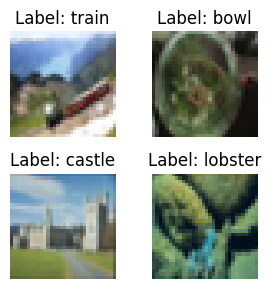

In [46]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
# Define the figure size
plt.figure(figsize=(3, 3))  # 3 columns and 4 rows

# Print images and labels for the first 4 images
for i in range(min(4, len(labels))):
    plt.subplot(2, 2, i+1)  # 2 rows, 2 columns, i+1 denotes the position of the subplot
    imshow(torchvision.utils.make_grid(images[i]))
    plt.title(f"Label: {classes[labels[i]]}")
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()


In [47]:
model = SimpleCNN().to(device)
model.load_state_dict(torch.load('cifar100_model.pth'))

<All keys matched successfully>

In [48]:
outputs = model(images)

In [49]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  crocodile willow_tree castle fox  


In [50]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 40 %


In [51]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: apple is 66.0 %
Accuracy for class: aquarium_fish is 54.0 %
Accuracy for class: baby  is 24.0 %
Accuracy for class: bear  is 17.0 %
Accuracy for class: beaver is 18.0 %
Accuracy for class: bed   is 46.0 %
Accuracy for class: bee   is 30.0 %
Accuracy for class: beetle is 43.0 %
Accuracy for class: bicycle is 58.0 %
Accuracy for class: bottle is 54.0 %
Accuracy for class: bowl  is 6.0 %
Accuracy for class: boy   is 21.0 %
Accuracy for class: bridge is 37.0 %
Accuracy for class: bus   is 32.0 %
Accuracy for class: butterfly is 33.0 %
Accuracy for class: camel is 32.0 %
Accuracy for class: can   is 46.0 %
Accuracy for class: castle is 59.0 %
Accuracy for class: caterpillar is 30.0 %
Accuracy for class: cattle is 26.0 %
Accuracy for class: chair is 62.0 %
Accuracy for class: chimpanzee is 52.0 %
Accuracy for class: clock is 35.0 %
Accuracy for class: cloud is 58.0 %
Accuracy for class: cockroach is 67.0 %
Accuracy for class: couch is 14.0 %
Accuracy for class: crab  is 3

In [53]:
# Define the FGSM attack and calculate ASR
attack_FGSM = torchattacks.FGSM(model, eps=8/255)
successful_attacks_FGSM = 0
total_samples = len(test_dataset)

for original_image, original_label in test_dataset:
    original_label_tensor = torch.tensor(original_label)
    adv_images_FGSM = attack_FGSM(original_image.unsqueeze(0), original_label_tensor.unsqueeze(0))
    original_prediction = torch.argmax(model(original_image.unsqueeze(0)))
    adversarial_prediction = torch.argmax(model(adv_images_FGSM))

    if original_prediction != adversarial_prediction:
        successful_attacks_FGSM += 1

success_rate_FGSM = successful_attacks_FGSM / total_samples
print("FGSM Success Rate:", success_rate_FGSM)

FGSM Success Rate: 0.8286


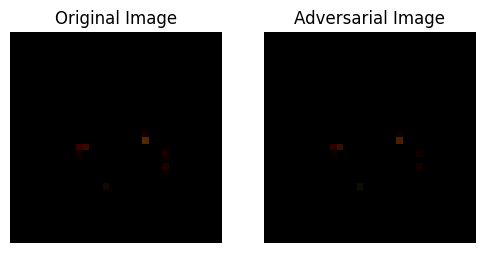

Original Label: 26
Original Prediction: dinosaur
Adversarial Prediction: cloud
Success Rate: 0.89


In [23]:
import torch
import torchattacks
import numpy as np
import matplotlib.pyplot as plt

# Define the FGSM attack
attack_FGSM = torchattacks.FGSM(model, eps=8/255)

# Function to get predictions
def get_prediction(image):
    return torch.argmax(model(image.unsqueeze(0)))

# Variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Use a subset of the dataset for speed

for i in range(total_samples):
    # Choose a random data point from the test dataset
    index_FGSM = np.random.randint(0, len(test_dataset))
    original_image_FGSM, original_label_FGSM = test_dataset[index_FGSM]

    # Ensure original_label is a PyTorch tensor
    original_label_tensor_FGSM = torch.tensor(original_label_FGSM)

    # Apply the FGSM attack to the original image
    adv_images_FGSM = attack_FGSM(original_image_FGSM.unsqueeze(0), original_label_tensor_FGSM.unsqueeze(0))

    # Predictions on original and adversarial images
    original_prediction_FGSM = get_prediction(original_image_FGSM)
    adversarial_prediction_FGSM = get_prediction(adv_images_FGSM.squeeze(0))

    if original_prediction_FGSM != adversarial_prediction_FGSM:
        successful_attacks += 1

    # Visualize the original image and adversarial image along with their predictions (for the first sample only)
    if i == 0:
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))

        axs[0].imshow(np.transpose(original_image_FGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(np.transpose(adv_images_FGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[1].set_title("Adversarial Image")
        axs[1].axis('off')

        plt.show()

        # Print the original and adversarial predictions
        print("Original Label:", original_label_FGSM)
        print("Original Prediction:", classes[original_prediction_FGSM.item()])
        print("Adversarial Prediction:", classes[adversarial_prediction_FGSM.item()])

# Calculate the success rate
success_rate = successful_attacks / total_samples

print("Success Rate:", success_rate)


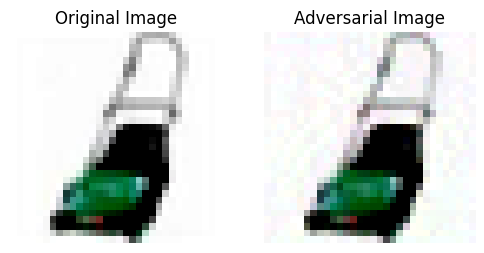

Original Label: 41
Original Prediction: lawn_mower
Adversarial Prediction: telephone
Success Rate: 0.83


In [54]:
import torch
import torchattacks
import numpy as np
import matplotlib.pyplot as plt

# Define the RFGSM attack
eps = 8 / 255
alpha = 2 / 255  # A small step size for random perturbation
attack_RFGSM = torchattacks.RFGSM(model, eps=eps, alpha=alpha)

# Function to get predictions
def get_prediction(image):
    return torch.argmax(model(image.unsqueeze(0)))

# Variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Use a subset of the dataset for speed

for i in range(total_samples):
    index_RFGSM = np.random.randint(0, len(test_dataset))
    original_image_RFGSM, original_label_RFGSM = test_dataset[index_RFGSM]

    original_label_tensor_RFGSM = torch.tensor(original_label_RFGSM)

    adv_images_RFGSM = attack_RFGSM(original_image_RFGSM.unsqueeze(0), original_label_tensor_RFGSM.unsqueeze(0))
    original_prediction_RFGSM = get_prediction(original_image_RFGSM)
    adversarial_prediction_RFGSM = get_prediction(adv_images_RFGSM.squeeze(0))

    # Check if the predictions differ
    if original_prediction_RFGSM != adversarial_prediction_RFGSM:
        successful_attacks += 1

    # Visualize the original image and adversarial image along with their predictions (for the first sample only)
    if i == 0:
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        axs[0].imshow(np.transpose(original_image_RFGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(np.transpose(adv_images_RFGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[1].set_title("Adversarial Image")
        axs[1].axis('off')

        plt.show()

        # Print the original and adversarial predictions
        print("Original Label:", original_label_RFGSM)
        print("Original Prediction:", classes[original_prediction_RFGSM.item()])
        print("Adversarial Prediction:", classes[adversarial_prediction_RFGSM.item()])
success_rate = successful_attacks / total_samples
print("Success Rate:", success_rate)


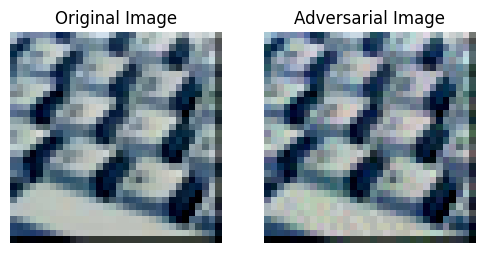

Original Label: 39
Original Prediction: keyboard
Adversarial Prediction: cloud
Success Rate: 0.87


In [55]:
import torch
import torchattacks
import numpy as np
import matplotlib.pyplot as plt

# Define the PGD attack
attack_PGD = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=40)

# Function to get predictions
def get_prediction(image):
    return torch.argmax(model(image.unsqueeze(0)))
successful_attacks = 0
total_samples = 100  # Use a subset of the dataset for speed

for i in range(total_samples):
    # Choose a random data point from the test dataset
    index_PGD = np.random.randint(0, len(test_dataset))
    original_image_PGD, original_label_PGD = test_dataset[index_PGD]

    # Ensure original_label is a PyTorch tensor
    original_label_tensor_PGD = torch.tensor(original_label_PGD)

    # Apply the PGD attack to the original image
    adv_images_PGD = attack_PGD(original_image_PGD.unsqueeze(0), original_label_tensor_PGD.unsqueeze(0))

    # Predictions on original and adversarial images
    original_prediction_PGD = get_prediction(original_image_PGD)
    adversarial_prediction_PGD = get_prediction(adv_images_PGD.squeeze(0))

    # Check if the predictions differ
    if original_prediction_PGD != adversarial_prediction_PGD:
        successful_attacks += 1

    # Visualize the original image and adversarial image along with their predictions (for the first sample only)
    if i == 0:
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        axs[0].imshow(np.transpose(original_image_PGD.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(np.transpose(adv_images_PGD.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[1].set_title("Adversarial Image")
        axs[1].axis('off')

        plt.show()

        print("Original Label:", original_label_PGD)
        print("Original Prediction:", classes[original_prediction_PGD.item()])
        print("Adversarial Prediction:", classes[adversarial_prediction_PGD.item()])

success_rate = successful_attacks / total_samples
print("Success Rate:", success_rate)


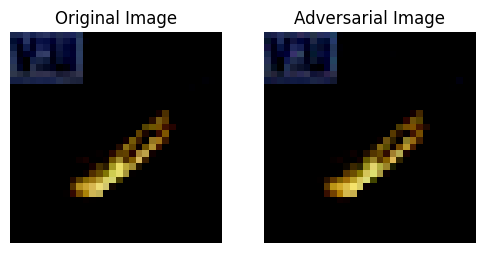

Original Label: 27
Original Prediction: crocodile
Adversarial Prediction: worm
Success Rate: 0.93


In [56]:
import torch
import torchattacks
import numpy as np
import matplotlib.pyplot as plt

# Define the EOTPGD attack
attack_EOTPGD = torchattacks.EOTPGD(model, eps=8/255, alpha=2/255, steps=10)

def get_prediction(image):
    return torch.argmax(model(image.unsqueeze(0)))

successful_attacks = 0
total_samples = 100  # Use a subset of the dataset for speed

for i in range(total_samples):
    # Choose a random data point from the test dataset
    index_EOTPGD = np.random.randint(0, len(test_dataset))
    original_image_EOTPGD, original_label_EOTPGD = test_dataset[index_EOTPGD]

    # Ensure original_label is a PyTorch tensor
    original_label_tensor_EOTPGD = torch.tensor(original_label_EOTPGD)

    # Apply the EOTPGD attack to the original image
    adv_images_EOTPGD = attack_EOTPGD(original_image_EOTPGD.unsqueeze(0), original_label_tensor_EOTPGD.unsqueeze(0))

    # Predictions on original and adversarial images
    original_prediction_EOTPGD = get_prediction(original_image_EOTPGD)
    adversarial_prediction_EOTPGD = get_prediction(adv_images_EOTPGD.squeeze(0))

    # Check if the predictions differ
    if original_prediction_EOTPGD != adversarial_prediction_EOTPGD:
        successful_attacks += 1

    # Visualize the original image and adversarial image along with their predictions (for the first sample only)
    if i == 0:
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        axs[0].imshow(np.transpose(original_image_EOTPGD.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(np.transpose(adv_images_EOTPGD.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[1].set_title("Adversarial Image")
        axs[1].axis('off')

        plt.show()
        print("Original Label:", original_label_EOTPGD)
        print("Original Prediction:", classes[original_prediction_EOTPGD.item()])
        print("Adversarial Prediction:", classes[adversarial_prediction_EOTPGD.item()])
success_rate = successful_attacks / total_samples
print("Success Rate:", success_rate)


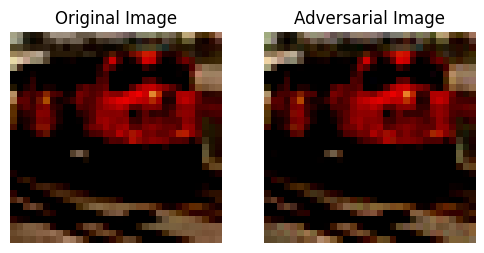

Original Label: 90
Original Prediction: tractor
Adversarial Prediction: aquarium_fish
Success Rate: 0.92


In [57]:
import torch
import torchattacks
import numpy as np
import matplotlib.pyplot as plt

# Define the FFGSM attack
attack_FFGSM = torchattacks.FFGSM(model)

# Function to get predictions
def get_prediction(image):
    return torch.argmax(model(image.unsqueeze(0)))

# Variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Use a subset of the dataset for speed

for i in range(total_samples):
    index_FFGSM = np.random.randint(0, len(test_dataset))
    original_image_FFGSM, original_label_FFGSM = test_dataset[index_FFGSM]

    original_label_tensor_FFGSM = torch.tensor(original_label_FFGSM)

    adv_images_FFGSM = attack_FFGSM(original_image_FFGSM.unsqueeze(0), original_label_tensor_FFGSM.unsqueeze(0))

    # Predictions on original and adversarial images
    original_prediction_FFGSM = get_prediction(original_image_FFGSM)
    adversarial_prediction_FFGSM = get_prediction(adv_images_FFGSM.squeeze(0))
    if original_prediction_FFGSM != adversarial_prediction_FFGSM:
        successful_attacks += 1

    # Visualize the original image and adversarial image along with their predictions (for the first sample only)
    if i == 0:
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        axs[0].imshow(np.transpose(original_image_FFGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(np.transpose(adv_images_FFGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[1].set_title("Adversarial Image")
        axs[1].axis('off')

        plt.show()
        print("Original Label:", original_label_FFGSM)
        print("Original Prediction:", classes[original_prediction_FFGSM.item()])
        print("Adversarial Prediction:", classes[adversarial_prediction_FFGSM.item()])

success_rate = successful_attacks / total_samples
print("Success Rate:", success_rate)


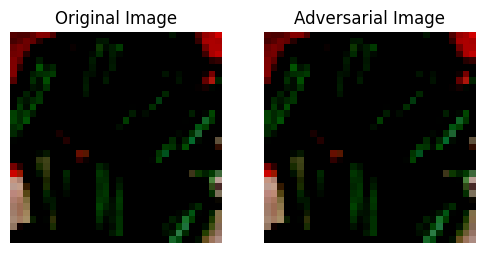

Original Label: 83
Original Prediction: sweet_pepper
Adversarial Prediction: worm
Success Rate: 0.82


In [59]:
import torch
import torchattacks
import numpy as np
import matplotlib.pyplot as plt

# Define the CW attack
attack_CW = torchattacks.CW(model, c=1, kappa=0, steps=50, lr=0.01)

# Function to get predictions
def get_prediction(image):
    return torch.argmax(model(image.unsqueeze(0)))

# Variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Use a subset of the dataset for speed

for i in range(total_samples):
    index_CW = np.random.randint(0, len(test_dataset))
    original_image_CW, original_label_CW = test_dataset[index_CW]

    original_label_tensor_CW = torch.tensor(original_label_CW)

    adv_images_CW = attack_CW(original_image_CW.unsqueeze(0), original_label_tensor_CW.unsqueeze(0))

    original_prediction_CW = get_prediction(original_image_CW)
    adversarial_prediction_CW = get_prediction(adv_images_CW.squeeze(0))

    if original_prediction_CW != adversarial_prediction_CW:
        successful_attacks += 1

    # Visualize the original image and adversarial image along with their predictions (for the first sample only)
    if i == 0:
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        axs[0].imshow(np.transpose(original_image_CW.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(np.transpose(adv_images_CW.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[1].set_title("Adversarial Image")
        axs[1].axis('off')

        plt.show()
        print("Original Label:", original_label_CW)
        print("Original Prediction:", classes[original_prediction_CW.item()])
        print("Adversarial Prediction:", classes[adversarial_prediction_CW.item()])

success_rate = successful_attacks / total_samples
print("Success Rate:", success_rate)


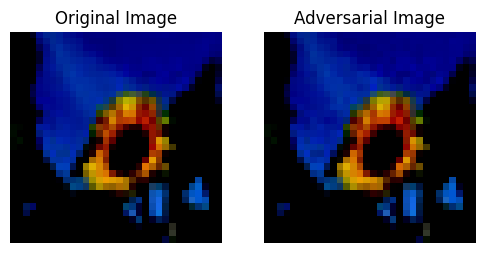

Original Label: 82
Original Prediction: sunflower
Adversarial Prediction: tiger
Success Rate: 0.33


In [60]:
import torch
import torchattacks
import numpy as np
import matplotlib.pyplot as plt

# Define the DeepFool attack
attack_DeepFool = torchattacks.DeepFool(model)

def get_prediction(image):
    return torch.argmax(model(image.unsqueeze(0)))

successful_attacks = 0
total_samples = 100  # Use a subset of the dataset for speed

for i in range(total_samples):
    index_DeepFool = np.random.randint(0, len(test_dataset))
    original_image_DeepFool, original_label_DeepFool = test_dataset[index_DeepFool]

    # Ensure original_label is a PyTorch tensor
    original_label_tensor_DeepFool = torch.tensor(original_label_DeepFool)

    adv_images_DeepFool = attack_DeepFool(original_image_DeepFool.unsqueeze(0), original_label_tensor_DeepFool.unsqueeze(0))

    # Predictions on original and adversarial images
    original_prediction_DeepFool = get_prediction(original_image_DeepFool)
    adversarial_prediction_DeepFool = get_prediction(adv_images_DeepFool.squeeze(0))

    # Check if the predictions differ
    if original_prediction_DeepFool != adversarial_prediction_DeepFool:
        successful_attacks += 1
    if i == 0:
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))

        axs[0].imshow(np.transpose(original_image_DeepFool.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(np.transpose(adv_images_DeepFool.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[1].set_title("Adversarial Image")
        axs[1].axis('off')

        plt.show()
        # Print the original and adversarial predictions
        print("Original Label:", original_label_DeepFool)
        print("Original Prediction:", classes[original_prediction_DeepFool.item()])
        print("Adversarial Prediction:", classes[adversarial_prediction_DeepFool.item()])

# Calculate the success rate
success_rate = successful_attacks / total_samples
print("Success Rate:", success_rate)


In [ ]:
import torch
import torchattacks
import numpy as np
import matplotlib.pyplot as plt

# Define the PGDL2 attack
attack_PGDL2 = torchattacks.PGDL2(model)

# Function to get predictions
def get_prediction(image):
    return torch.argmax(model(image.unsqueeze(0)))

# Variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Use a subset of the dataset for speed

for i in range(total_samples):
    # Choose a random data point from the test dataset
    index_PGDL2 = np.random.randint(0, len(test_dataset))
    original_image_PGDL2, original_label_PGDL2 = test_dataset[index_PGDL2]

    # Ensure original_label is a PyTorch tensor
    original_label_tensor_PGDL2 = torch.tensor(original_label_PGDL2)

    # Apply the PGDL2 attack to the original image
    adv_images_PGDL2 = attack_PGDL2(original_image_PGDL2.unsqueeze(0), original_label_tensor_PGDL2.unsqueeze(0))

    # Predictions on original and adversarial images
    original_prediction_PGDL2 = get_prediction(original_image_PGDL2)
    adversarial_prediction_PGDL2 = get_prediction(adv_images_PGDL2.squeeze(0))

    # Check if the predictions differ
    if original_prediction_PGDL2 != adversarial_prediction_PGDL2:
        successful_attacks += 1

    # Visualize the original image and adversarial image along with their predictions (for the first sample only)
    if i == 0:
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))

        # Original image
        axs[0].imshow(np.transpose(original_image_PGDL2.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        # Adversarial image
        axs[1].imshow(np.transpose(adv_images_PGDL2.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[1].set_title("Adversarial Image")
        axs[1].axis('off')

        plt.show()

        # Print the original and adversarial predictions
        print("Original Label:", original_label_PGDL2)
        print("Original Prediction:", classes[original_prediction_PGDL2.item()])
        print("Adversarial Prediction:", classes[adversarial_prediction_PGDL2.item()])

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)


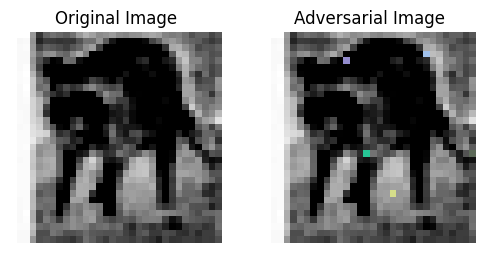

Original Label: 66
Original Prediction: wolf
Adversarial Prediction: wolf
Success Rate: 0.4


In [62]:

import torch
import torchattacks
import numpy as np
import matplotlib.pyplot as plt

# Define the OnePixel attack
attack_OnePixel = torchattacks.OnePixel(model, pixels=5)

# Function to get predictions
def get_prediction(image):
    return torch.argmax(model(image.unsqueeze(0)))

# Variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Use a subset of the dataset for speed

for i in range(total_samples):
    # Choose a random data point from the test dataset
    index_OnePixel = np.random.randint(0, len(test_dataset))
    original_image_OnePixel, original_label_OnePixel = test_dataset[index_OnePixel]

    # Ensure original_label is a PyTorch tensor
    original_label_tensor_OnePixel = torch.tensor(original_label_OnePixel)

    # Apply the OnePixel attack to the original image
    adv_images_OnePixel = attack_OnePixel(original_image_OnePixel.unsqueeze(0), original_label_tensor_OnePixel.unsqueeze(0))

    # Predictions on original and adversarial images
    original_prediction_OnePixel = get_prediction(original_image_OnePixel)
    adversarial_prediction_OnePixel = get_prediction(adv_images_OnePixel.squeeze(0))

    # Check if the predictions differ
    if original_prediction_OnePixel != adversarial_prediction_OnePixel:
        successful_attacks += 1

    # Visualize the original image and adversarial image along with their predictions (for the first sample only)
    if i == 0:
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))

        # Original image
        axs[0].imshow(np.transpose(original_image_OnePixel.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        # Adversarial image
        axs[1].imshow(np.transpose(adv_images_OnePixel.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[1].set_title("Adversarial Image")
        axs[1].axis('off')

        plt.show()

        # Print the original and adversarial predictions
        print("Original Label:", original_label_OnePixel)
        print("Original Prediction:", classes[original_prediction_OnePixel.item()])
        print("Adversarial Prediction:", classes[adversarial_prediction_OnePixel.item()])

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)


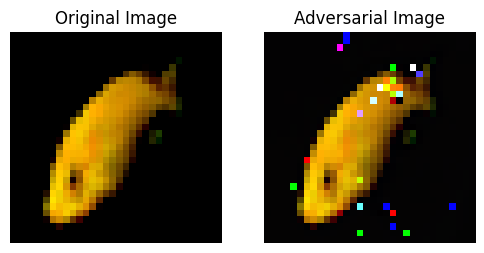

Original Label: 1
Original Prediction: aquarium_fish
Adversarial Prediction: lamp
Success Rate: 0.4


In [61]:
import torch
import torchattacks
import numpy as np
import matplotlib.pyplot as plt

# Define the SparseFool attack
attack_SparseFool = torchattacks.SparseFool(model)

# Function to get predictions
def get_prediction(image):
    return torch.argmax(model(image.unsqueeze(0)))

# Variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Use a subset of the dataset for speed

for i in range(total_samples):
    # Choose a random data point from the test dataset
    index_SparseFool = np.random.randint(0, len(test_dataset))
    original_image_SparseFool, original_label_SparseFool = test_dataset[index_SparseFool]

    # Ensure original_label is a PyTorch tensor
    original_label_tensor_SparseFool = torch.tensor(original_label_SparseFool)

    # Apply the SparseFool attack to the original image
    adv_images_SparseFool = attack_SparseFool(original_image_SparseFool.unsqueeze(0), original_label_tensor_SparseFool.unsqueeze(0))

    # Predictions on original and adversarial images
    original_prediction_SparseFool = get_prediction(original_image_SparseFool)
    adversarial_prediction_SparseFool = get_prediction(adv_images_SparseFool.squeeze(0))

    # Check if the predictions differ
    if original_prediction_SparseFool != adversarial_prediction_SparseFool:
        successful_attacks += 1

    # Visualize the original image and adversarial image along with their predictions (for the first sample only)
    if i == 0:
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))

        # Original image
        axs[0].imshow(np.transpose(original_image_SparseFool.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        # Adversarial image
        axs[1].imshow(np.transpose(adv_images_SparseFool.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        axs[1].set_title("Adversarial Image")
        axs[1].axis('off')

        plt.show()

        # Print the original and adversarial predictions
        print("Original Label:", original_label_SparseFool)
        print("Original Prediction:", classes[original_prediction_SparseFool.item()])
        print("Adversarial Prediction:", classes[adversarial_prediction_SparseFool.item()])

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)


Original Label: 88
The image has likely been attacked by an adversarial perturbation.


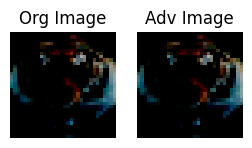

Original Prediction: tiger
Adversarial Prediction: worm
Success Rate: 0.0001


In [30]:
#PGDL2 Attack

attack_PGDL2 = torchattacks.PGDL2(model, eps = 1, alpha = 0.2, steps = 10, random_start = True)
# (model, eps = 1, alpha = 0.2, steps = 10, random_start = True, eps_for_division = 1e-10)

# Choose a random data point from the test dataset
index_PGDL2 = np.random.randint(0, len(test_dataset))
original_image_PGDL2, original_label_PGDL2 = test_dataset[index_PGDL2]
print("Original Label:", original_label_PGDL2)

# Ensure original_label is a PyTorch tensor
original_label_tensor_PGDL2 = torch.tensor(original_label_PGDL2)

# Apply the PGDL2 attack to the original image
adv_images_PGDL2 = attack_PGDL2(original_image_PGDL2.unsqueeze(0), original_label_tensor_PGDL2.unsqueeze(0))

# Predictions on original and adversarial images
original_prediction_PGDL2 = torch.argmax(model(original_image_PGDL2.unsqueeze(0)))
adversarial_prediction_PGDL2 = torch.argmax(model(adv_images_PGDL2))

# Check if the predictions differ
if original_prediction_PGDL2 != adversarial_prediction_PGDL2:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")


# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))


# Original image
axs[0].imshow(np.transpose(original_image_PGDL2.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_PGDL2.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()


# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_PGDL2.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_PGDL2.item()])


# Check if the predictions differ

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_PGDL2 != adversarial_prediction_PGDL2:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)



Original Label: 58
The image has likely been attacked by an adversarial perturbation.


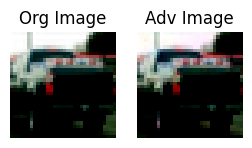

Original Prediction: pickup_truck
Adversarial Prediction: table
Success Rate: 0.0001


In [31]:
# PGDRSL2 Attack

attack_PGDRSL2 = torchattacks.PGDRSL2(model, eps = 1, steps = 10)
# eps: float = 1, alpha: float = 0.2, steps: int = 10, noise_type: str = "guassian", noise_sd: float = 0.5, noise_batch_size: int = 5, batch_max: int = 2048, eps_for_division: float = 1e-10)

# Choose a random data point from the test dataset
index_PGDRSL2 = np.random.randint(0, len(test_dataset))
original_image_PGDRSL2, original_label_PGDRSL2 = test_dataset[index_PGDRSL2]
print("Original Label:", original_label_PGDRSL2)

# Ensure original_label is a PyTorch tensor
original_label_tensor_PGDRSL2 = torch.tensor(original_label_PGDRSL2)

# Apply the PGDRSL2 attack to the original image
adv_images_PGDRSL2 = attack_PGDRSL2(original_image_PGDRSL2.unsqueeze(0), original_label_tensor_PGDRSL2.unsqueeze(0))

# Predictions on original and adversarial images
original_prediction_PGDRSL2 = torch.argmax(model(original_image_PGDRSL2.unsqueeze(0)))
adversarial_prediction_PGDRSL2 = torch.argmax(model(adv_images_PGDRSL2))

# Check if the predictions differ
if original_prediction_PGDRSL2 != adversarial_prediction_PGDRSL2:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")


# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))


# Original image
axs[0].imshow(np.transpose(original_image_PGDRSL2.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_PGDRSL2.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()


# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_PGDRSL2.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_PGDRSL2.item()])


# Check if the predictions differ

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_PGDRSL2 != adversarial_prediction_PGDRSL2:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)

Original Label: 31
The image has not been attacked by an adversarial perturbation.


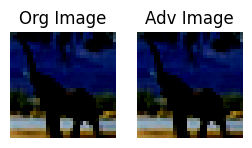

Original Prediction: bear
Adversarial Prediction: bear
Success Rate: 0.0


In [33]:
# SparseFool Attack

attack_SparseFool = torchattacks.SparseFool(model)

# Choose a random data point from the test dataset
index_SparseFool = np.random.randint(0, len(test_dataset))
original_image_SparseFool, original_label_SparseFool = test_dataset[index_SparseFool]
print("Original Label:", original_label_SparseFool)

# Ensure original_label is a PyTorch tensor
original_label_tensor_SparseFool = torch.tensor(original_label_SparseFool)

# Apply the SparseFool attack to the original image
adv_images_SparseFool = attack_SparseFool(original_image_SparseFool.unsqueeze(0), original_label_tensor_SparseFool.unsqueeze(0))

# Predictions on original and adversarial images
original_prediction_SparseFool = torch.argmax(model(original_image_SparseFool.unsqueeze(0)))
adversarial_prediction_SparseFool = torch.argmax(model(adv_images_SparseFool))

# Check if the predictions differ
if original_prediction_SparseFool!= adversarial_prediction_SparseFool:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")


# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))


# Original image
axs[0].imshow(np.transpose(original_image_SparseFool.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_SparseFool.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()


# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_SparseFool.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_SparseFool.item()])


# Check if the predictions differ

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_SparseFool != adversarial_prediction_SparseFool:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)

Original Label: 26


The image has likely been attacked by an adversarial perturbation.


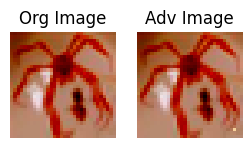

Original Prediction: crab
Adversarial Prediction: snake
Success Rate: 0.0001


In [34]:
# OnePixel Attack

attack_OnePixel = torchattacks.OnePixel(model, pixels = 1, steps = 10, popsize = 10, inf_batch = 128)

# Choose a random data point from the test dataset
index_OnePixel = np.random.randint(0, len(test_dataset))
original_image_OnePixel, original_label_OnePixel = test_dataset[index_OnePixel]
print("Original Label:", original_label_OnePixel)

# Ensure original_label is a PyTorch tensor
original_label_tensor_OnePixel = torch.tensor(original_label_OnePixel)

# Apply the OnePixel attack to the original image
adv_images_OnePixel = attack_OnePixel(original_image_OnePixel.unsqueeze(0), original_label_tensor_OnePixel.unsqueeze(0))

# Predictions on original and adversarial images
original_prediction_OnePixel = torch.argmax(model(original_image_OnePixel.unsqueeze(0)))
adversarial_prediction_OnePixel = torch.argmax(model(adv_images_OnePixel))

# Check if the predictions differ
if original_prediction_OnePixel != adversarial_prediction_OnePixel:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")


# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))


# Original image
axs[0].imshow(np.transpose(original_image_OnePixel.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_OnePixel.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()


# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_OnePixel.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_OnePixel.item()])


# Check if the predictions differ

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_OnePixel != adversarial_prediction_OnePixel:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)


Original Label: 93
The image has not been attacked by an adversarial perturbation.


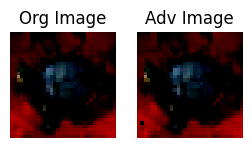

Original Prediction: bowl
Adversarial Prediction: bowl
Success Rate: 0.0


In [35]:
# Pixle Attack

attack_Pixle = torchattacks.Pixle(model, restarts = 20, max_iterations = 10 )
# (model, x_dimensions: Any = (2, 10), y_dimensions: Any = (2, 10), pixel_mapping: str = "random", restarts: int = 20, max_iterations: int = 10, update_each_iteration: bool = False)

# Choose a random data point from the test dataset
index_Pixle = np.random.randint(0, len(test_dataset))
original_image_Pixle, original_label_Pixle = test_dataset[index_Pixle]
print("Original Label:", original_label_Pixle)

# Ensure original_label is a PyTorch tensor
original_label_tensor_Pixle = torch.tensor(original_label_Pixle)

# Apply the Pixle attack to the original image
adv_images_Pixle = attack_Pixle(original_image_Pixle.unsqueeze(0), original_label_tensor_Pixle.unsqueeze(0))

# Predictions on original and adversarial images
original_prediction_Pixle = torch.argmax(model(original_image_Pixle.unsqueeze(0)))
adversarial_prediction_Pixle = torch.argmax(model(adv_images_Pixle))

# Check if the predictions differ
if original_prediction_Pixle != adversarial_prediction_Pixle:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")


# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))


# Original image
axs[0].imshow(np.transpose(original_image_Pixle.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_Pixle.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()


# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_Pixle.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_Pixle.item()])


# Check if the predictions differ

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_Pixle != adversarial_prediction_Pixle:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)


Original Label: 16


The image has not been attacked by an adversarial perturbation.


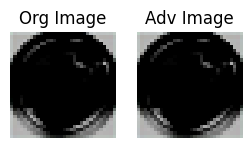

Original Prediction: clock
Adversarial Prediction: clock
Success Rate: 0.0


In [36]:
# FAB Attack

attack_FAB = torchattacks.FAB(model, eps = 8 / 255, steps = 10, seed = 0 )

# Choose a random data point from the test dataset
index_FAB = np.random.randint(0, len(test_dataset))
original_image_FAB, original_label_FAB = test_dataset[index_FAB]
print("Original Label:", original_label_FAB)

# Ensure original_label is a PyTorch tensor
original_label_tensor_FAB = torch.tensor(original_label_FAB)

# Apply the FAB attack to the original image
adv_images_FAB = attack_FAB(original_image_FAB.unsqueeze(0), original_label_tensor_FAB.unsqueeze(0))

# Predictions on original and adversarial images
original_prediction_FAB = torch.argmax(model(original_image_FAB.unsqueeze(0)))
adversarial_prediction_FAB = torch.argmax(model(adv_images_FAB))

# Check if the predictions differ
if original_prediction_FAB != adversarial_prediction_FAB:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")


# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))


# Original image
axs[0].imshow(np.transpose(original_image_FAB.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_FAB.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()


# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_FAB.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_FAB.item()])


# Check if the predictions differ

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_FAB != adversarial_prediction_FAB:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)
